In [1]:
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from typing import Union, List

%load_ext autoreload 
%autoreload 2

In [2]:
%%time

def write_to_submission_file(predicted_probs, out_file: str = 'to_submission.csv.zip',
                             target='target', index_label='session_id'):
    df = pd.DataFrame(predicted_probs,
                      index=np.arange(1, len(predicted_probs) + 1),
                      columns=[target])
    df.to_csv(out_file, index_label=index_label, compression="zip")

def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    """ Define all type transformations in a single function """
    sites = [s for s in df.columns if "site" in s]
    df[sites] = df[sites].fillna(0).astype('uint16')
    times = [t for t in df.columns if "time" in t]
    df[times] = df[times].apply(pd.to_datetime)
    if 'target' in df.columns:
        df['target'] = df.target.astype('uint8')
    return df

train_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv.zip')
train_df = convert_types(train_df)
train_df.sort_values(by='time1', inplace=True)

test_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv.zip')
test_df = convert_types(test_df)

sites = [s for s in train_df.columns if 'site' in s]
times = [t for t in train_df.columns if 'time' in t]

# Our target variable
y_train = train_df["target"]

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

sites_corpus = full_df[sites].to_string(header=False, index=False).split('\n')

tfv = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train = tfv.fit_transform(sites_corpus[:idx_split])
X_test = tfv.transform(sites_corpus[idx_split:])

X_full = vstack([X_train, X_test]).tocsr()


def get_auc_logit_score(X, y, C=1.0, seed=17, n_splits=10):
    # Split the data into the training and validation sets
    time_split = TimeSeriesSplit(n_splits=n_splits)
    logit = LogisticRegression(C=C, random_state=seed, solver='liblinear')
    cv_scores = cross_val_score(logit, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()


def get_features(full_df) -> pd.DataFrame:
    times = [t for t in full_df.columns if 'time' in t]
    feat_df = pd.DataFrame(index=full_df.index)

    feat_df['weekday'] = full_df['time1'].dt.weekday
    for weekday in range(7):
        feat_name = f'weekday_{weekday}'
        feat_df[feat_name] = (full_df['time1'].dt.weekday == weekday).astype(int)
    for hour in range(23):
        feat_name = f'hour_{hour}'
        feat_df[feat_name] = (full_df['time1'].dt.hour == hour).astype(int)

    feat_df['duration'] = (full_df[times].max(axis=1) - full_df[times].min(axis=1)).dt.total_seconds()

    feat_df['hour_sin'] = np.sin(full_df['time1'].dt.hour / 24)
    feat_df['hour_cos'] = np.cos(full_df['time1'].dt.hour / 24)

    feat_df['hour'] = full_df['time1'].dt.hour

    feat_df['morning'] = feat_df['hour'].between(7, 11).astype(int)
    feat_df['noon'] = feat_df['hour'].between(12, 18).astype(int)
    feat_df['evening'] = feat_df['hour'].between(19, 23).astype(int)
    feat_df['night'] = feat_df['hour'].between(0, 6).astype(int)

    deltas = ['delta' + str(i) for i in range(1, 10)]    
    delta_df = (full_df[times] - full_df[times].shift(1, axis=1)) \
        .copy() \
        .drop(columns='time1') \
        .apply(lambda x: x.dt.total_seconds())

    delta_df.columns = deltas
    for delta in deltas:
        feat_df[delta] = delta_df[delta]

    feat_df['delta_avg'] = delta_df.mean(axis=1, skipna=True).fillna(0.0)

    best_hours = ['hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_14', 'hour_16', 'hour_17', 'hour_18',
                  'hour_19', 'hour_20', 'hour_21', 'hour_22']
    best_weekdays = ['weekday_0']
    best_previous = ['morning', 'noon', 'evening']

    return feat_df

# Add the new feature to the sparse matrix
def add_feature(feat: str, X_sparse, standardize=True, onehot=False):
    tmp = feat_df[[feat]].values
    if onehot:
        enc = OneHotEncoder(dtype=np.uint8, sparse=False)
        tmp = enc.fit_transform(tmp)
    if standardize:
        tmp = StandardScaler().fit_transform(tmp)
    return hstack([X_sparse, tmp]).tocsr()


def add_multi_feature(feat_list: list):
    X_new = X_full
    for feat in feat_list:
        X_new = add_feature(feat, X_new)
    return X_new[:idx_split, :], X_new[idx_split:, :]


def test_feature(features: Union[list, str], standardize=True, onehot=False, C=1):
    print(f"Testing:\t{features}")

    if isinstance(features, str):
        features = [features]
    
    X_new = X_full
    for feat in features:
        X_new = add_feature(feat, X_new, onehot=onehot, standardize=standardize)
    X_train_new = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train_new, y_train, C=C)

    print(f"Score:\t\t{score:.4f}\t", end="")

    if score > BASELINE:
        print(f"+++ baseline:\t{BASELINE:.4f}")
    else:
        print(f"--- baseline:\t{BASELINE:.4f}")
    return score


def test_multi_feature(feat_list: list, C=1):
    """
    Deprecated
    """
    print(f"Testing:\t{feat_list}")

    X_new = X_full
    for feat in feat_list:
        X_new = add_feature(feat, X_sparse=X_new)
    X_train_new = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train_new, y_train, C=C)

    print(f"Score:\t\t{score:.4f}\t", end="")
    if score > BASELINE:
        print(f"+++ baseline: {BASELINE:.4f}")
    else:
        print(f"--- baseline: {BASELINE:.4f}")
    return score


def predict_probs(feat_list: list = None, C=1):
    X_new = X_full

    if feat_list is not None:
        for feat in feat_list:
            X_new = add_feature(feat, X_sparse=X_new)
    else:
        pass

    X_train_new = X_new[:idx_split, :]
    X_test_new = X_new[idx_split:, :]
    estimator = LogisticRegression(C=C, random_state=17, solver='liblinear')
    estimator.fit(X_train_new, y_train)
    print(f"Local score: {get_auc_logit_score(X_train_new, y_train, C=C):.4f}")
    return estimator.predict_proba(X_test_new)[:, 1]


BASELINE = get_auc_logit_score(X_train, y_train)

feat_df = get_features(full_df)

Wall time: 33.4 s


In [3]:
feat_df.columns

Index(['weekday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'duration', 'hour_sin', 'hour_cos', 'hour', 'morning',
       'noon', 'evening', 'night', 'delta1', 'delta2', 'delta3', 'delta4',
       'delta5', 'delta6', 'delta7', 'delta8', 'delta9', 'delta_avg'],
      dtype='object')

<AxesSubplot:xlabel='weekday', ylabel='Density'>

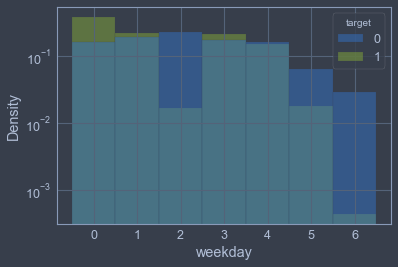

In [4]:
import seaborn as sns
sns.histplot(x='weekday',
             hue=y_train,
             data=feat_df[:idx_split],
             stat='density',
             common_norm=False,
#              multiple="dodge",
#              binwidth=1,
             discrete=True,
             log_scale=(False, True)
             )

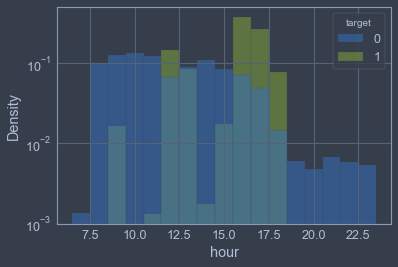

In [10]:
sns.histplot(x='hour', 
             hue=y_train,
             data=feat_df[:idx_split],
             stat='density',
             common_norm=False,
#              multiple="dodge",
#              binwidth=1,
             discrete=True,
             log_scale=(False, True))
plt.show()

<AxesSubplot:xlabel='duration', ylabel='Density'>

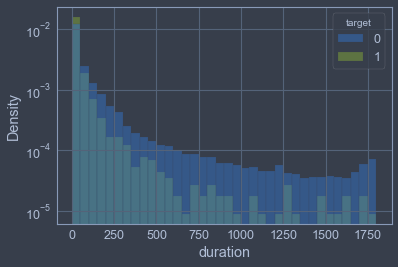

In [6]:
sns.histplot(x='duration',
             hue=y_train,
             data=feat_df[:idx_split],
             stat='density',
             common_norm=False,
#              multiple="dodge",
             binwidth=50,
#              discrete=True,
             log_scale=(False, True))

<AxesSubplot:xlabel='delta_avg', ylabel='Density'>

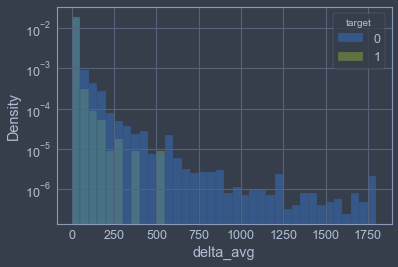

In [7]:
sns.histplot(x='delta_avg',
             hue=y_train,
             data=feat_df[:idx_split],
             stat='density',
             common_norm=False,
#              multiple="dodge",
             binwidth=50,
#              discrete=True,
             log_scale=(False, True))